In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, re, random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

dataset_path = "/content/drive/MyDrive/obss-intern-competition-2025"
image_dir    = f"{dataset_path}/train/train"
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE    = 16
EMBED_SIZE    = 256
HIDDEN_SIZE   = 512
LEARNING_RATE = 1e-4
EPOCHS        = 40
MAX_LEN       = 20
TEMPERATURE   = 0.8

PAD_TOKEN   = "<pad>"
START_TOKEN = "<start>"
END_TOKEN   = "<end>"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Veri Okuma, Temizleme, Vocabulary & DataLoader
def clean_caption(c):
    c = c.lower()
    c = re.sub(r'[^a-zığüşöçıİĞÜŞÖÇ0-9\s]', '', c)
    return c.strip()

# CSV oku ve temizle
df = pd.read_csv(f"{dataset_path}/train.csv")  
df['caption']  = df['caption'].apply(clean_caption)
df['image_id'] = df['image_id'].astype(str).apply(
    lambda x: x if x.lower().endswith('.jpg') else f"{x}.jpg"
)

# Vocabulary oluştur
freq = {}
for cap in df['caption']:
    for w in cap.split():
        freq[w] = freq.get(w,0)+1
words = [w for w,c in freq.items() if c>=5]
vocab = [PAD_TOKEN, START_TOKEN, END_TOKEN] + words
word2idx = {w:i for i,w in enumerate(vocab)}
idx2word = {i:w for w,i in word2idx.items()}

# Dataset ve DataLoader
class CaptionDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df      = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tf      = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(os.path.join(self.img_dir, row.image_id)).convert("RGB")
        img = self.tf(img)
        tokens = [word2idx[START_TOKEN]] + \
                 [word2idx.get(w, word2idx[PAD_TOKEN]) for w in row.caption.split()[:MAX_LEN-2]] + \
                 [word2idx[END_TOKEN]]
        if len(tokens) < MAX_LEN:
            tokens += [word2idx[PAD_TOKEN]] * (MAX_LEN - len(tokens))
        return img, torch.tensor(tokens)

transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
ds     = CaptionDataset(df, image_dir, transform)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# Model Tanımları (Encoder w/ ResNet-50, Attention, Decoder RNN) 
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.embed_size = embed_size
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.backbone      = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7,7))
        self.conv          = nn.Conv2d(2048, embed_size, 1)
    def forward(self, images):
        x = self.backbone(images)
        x = self.adaptive_pool(x)
        f = self.conv(x)
        B,C,H,W = f.size()
        f = f.view(B, C, H*W).permute(0,2,1)
        return f  

class Attention(nn.Module):
    def __init__(self, embed_size, hidden_size):
        super().__init__()
        self.attn_enc  = nn.Linear(embed_size, hidden_size)
        self.attn_dec  = nn.Linear(hidden_size, hidden_size)
        self.full_attn = nn.Linear(hidden_size, 1)
    def forward(self, enc_feats, hidden):
        e      = torch.tanh(self.attn_enc(enc_feats) + self.attn_dec(hidden).unsqueeze(1))
        scores = self.full_attn(e).squeeze(-1)
        alpha  = torch.softmax(scores, dim=1)
        context= (enc_feats * alpha.unsqueeze(-1)).sum(1)
        return context, alpha

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.attn    = Attention(embed_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm    = nn.LSTMCell(embed_size*2, hidden_size)
        self.linear  = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    def forward(self, enc_feats, captions):
        B = enc_feats.size(0)
        h = torch.zeros(B, HIDDEN_SIZE, device=device)
        c = torch.zeros(B, HIDDEN_SIZE, device=device)
        outputs = torch.zeros(B, MAX_LEN, len(vocab), device=device)
        for t in range(MAX_LEN-1):
            emb    = self.embedding(captions[:,t])
            ctx,_  = self.attn(enc_feats, h)
            h, c   = self.lstm(torch.cat([emb, ctx], dim=1), (h,c))
            outputs[:,t+1,:] = self.linear(self.dropout(h))
        return outputs

In [ ]:
# Model Başlatma, Loss, Optimizer 
torch.cuda.empty_cache()
vocab_size = len(vocab)
encoder    = EncoderCNN(EMBED_SIZE).to(device)
decoder    = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, vocab_size).to(device)


for p in encoder.backbone.parameters():
    p.requires_grad = False

criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD_TOKEN])
params    = list(decoder.parameters()) + list(encoder.conv.parameters())
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)
scaler    = GradScaler()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-67-d094abdf6bec>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()


In [ ]:
# Eğitim Döngüsü (Tqdm + Doğru avg_loss Hesabı) 
from torch.amp import autocast
from tqdm.notebook import trange, tqdm

for epoch in trange(EPOCHS, desc='Epochs'):
    encoder.train()
    decoder.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    for i, (imgs, caps) in enumerate(pbar, 1):
        imgs, caps = imgs.to(device), caps.to(device)
        optimizer.zero_grad()

        with autocast('cuda'):
            enc_feats = encoder(imgs)
            outputs   = decoder(enc_feats, caps[:, :-1])               
            preds     = outputs[:, 1:, :].reshape(-1, vocab_size)      
            targets   = caps[:, 1:].reshape(-1)                        
            loss      = criterion(preds, targets)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(
            filter(lambda p: p.requires_grad,
                   list(decoder.parameters()) + list(encoder.parameters())),
            max_norm=5
        )
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        avg_loss = total_loss / i
        pbar.set_postfix(loss=f'{loss.item():.4f}', avg_loss=f'{avg_loss:.4f}')

    print(f"→ End Epoch {epoch+1}/{EPOCHS} — Avg Loss: {total_loss/len(loader):.4f}")
    torch.cuda.empty_cache()

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 1/40 — Avg Loss: 5.3515


Epoch 2/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 2/40 — Avg Loss: 4.5789


Epoch 3/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 3/40 — Avg Loss: 4.2214


Epoch 4/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 4/40 — Avg Loss: 3.9834


Epoch 5/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 5/40 — Avg Loss: 3.8114


Epoch 6/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 6/40 — Avg Loss: 3.6722


Epoch 7/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 7/40 — Avg Loss: 3.5596


Epoch 8/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 8/40 — Avg Loss: 3.4602


Epoch 9/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 9/40 — Avg Loss: 3.3751


Epoch 10/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 10/40 — Avg Loss: 3.2991


Epoch 11/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 11/40 — Avg Loss: 3.2318


Epoch 12/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 12/40 — Avg Loss: 3.1706


Epoch 13/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 13/40 — Avg Loss: 3.1122


Epoch 14/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 14/40 — Avg Loss: 3.0595


Epoch 15/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 15/40 — Avg Loss: 3.0086


Epoch 16/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 16/40 — Avg Loss: 2.9627


Epoch 17/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 17/40 — Avg Loss: 2.9177


Epoch 18/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 18/40 — Avg Loss: 2.8746


Epoch 19/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 19/40 — Avg Loss: 2.8341


Epoch 20/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 20/40 — Avg Loss: 2.7964


Epoch 21/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 21/40 — Avg Loss: 2.7604


Epoch 22/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 22/40 — Avg Loss: 2.7251


Epoch 23/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 23/40 — Avg Loss: 2.6894


Epoch 24/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 24/40 — Avg Loss: 2.6560


Epoch 25/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 25/40 — Avg Loss: 2.6243


Epoch 26/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 26/40 — Avg Loss: 2.5918


Epoch 27/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 27/40 — Avg Loss: 2.5630


Epoch 28/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 28/40 — Avg Loss: 2.5335


Epoch 29/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 29/40 — Avg Loss: 2.5068


Epoch 30/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 30/40 — Avg Loss: 2.4788


Epoch 31/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 31/40 — Avg Loss: 2.4491


Epoch 32/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 32/40 — Avg Loss: 2.4256


Epoch 33/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 33/40 — Avg Loss: 2.3973


Epoch 34/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 34/40 — Avg Loss: 2.3740


Epoch 35/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 35/40 — Avg Loss: 2.3496


Epoch 36/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 36/40 — Avg Loss: 2.3245


Epoch 37/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 37/40 — Avg Loss: 2.2982


Epoch 38/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 38/40 — Avg Loss: 2.2775


Epoch 39/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 39/40 — Avg Loss: 2.2514


Epoch 40/40:   0%|          | 0/1336 [00:00<?, ?it/s]

→ End Epoch 40/40 — Avg Loss: 2.2276


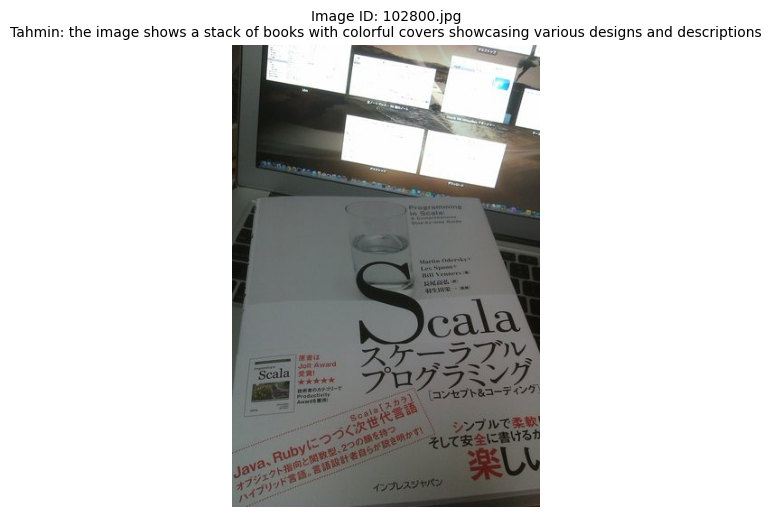

In [ ]:
# Inference on TEST Görselleri 
import matplotlib.pyplot as plt

test_df = pd.read_csv(f"{dataset_path}/test.csv") 
test_dir = f"{dataset_path}/test/test"

def generate_caption(image_path, temperature=TEMPERATURE):
    encoder.eval(); decoder.eval()
    img_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    enc_feats  = encoder(img_tensor)
    h = torch.zeros(1, HIDDEN_SIZE, device=device)
    c = torch.zeros(1, HIDDEN_SIZE, device=device)
    idx = word2idx[START_TOKEN]
    caption = []
    for _ in range(MAX_LEN):
        emb    = decoder.embedding(torch.tensor([idx], device=device))
        ctx,_  = decoder.attn(enc_feats, h)
        h, c   = decoder.lstm(torch.cat([emb, ctx], dim=1), (h, c))
        logits = decoder.linear(h) / temperature
        probs  = torch.softmax(logits, dim=-1)
        idx    = torch.multinomial(probs, 1).item()
        if idx == word2idx[END_TOKEN]:
            break
        caption.append(idx2word.get(idx, PAD_TOKEN))
    return " ".join(caption)

sample_id = random.choice(test_df['image_id'].astype(str).tolist())
if not sample_id.lower().endswith('.jpg'):
    sample_id += '.jpg'

img_path = os.path.join(test_dir, sample_id)
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Test görseli bulunamadı: {img_path}")

cap = generate_caption(img_path)

plt.figure(figsize=(6,6))
plt.imshow(Image.open(img_path))
plt.axis('off')
plt.title(f"Image ID: {sample_id}\nTahmin: {cap}", fontsize=10)
plt.show()

In [ ]:
# TEST Görselleri için Caption Oluştur & CSV’ye Kaydet
from tqdm.notebook import tqdm

captions = []

for img_id in tqdm(test_df['image_id'].astype(str).tolist(), desc="Generating captions"):
    fname = img_id if img_id.lower().endswith('.jpg') else f"{img_id}.jpg"
    img_path = os.path.join(test_dir, fname)
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Test görseli bulunamadı: {img_path}")
    cap = generate_caption(img_path)
    captions.append(cap)

test_df['caption'] = captions

submission_path = f"{dataset_path}/submission.csv"
test_df.to_csv(submission_path, index=False)
print(f"Submission dosyası oluşturuldu: {submission_path}")

Generating captions:   0%|          | 0/3771 [00:00<?, ?it/s]

Submission dosyası oluşturuldu: /content/drive/MyDrive/obss-intern-competition-2025/submission.csv
